### EMA 3 lines strategy

In [1]:
import time
from datetime import datetime

import pandas as pd
import pandas_ta as ta
import numpy as np
import mplfinance as mpf

### import csv

In [2]:
data = pd.read_csv('USDJPY_15m_2022_01_03.csv')
data.tail()

,timestamp,open,high,low,close,adj close,volumn
3887,2021-12-31 20:45:00+00:00,115.051003,115.110001,115.010002,115.095001,115.095001,0
3888,2021-12-31 21:00:00+00:00,115.091003,115.095001,115.029999,115.056999,115.056999,0
3889,2021-12-31 21:15:00+00:00,115.056999,115.073997,115.019997,115.061996,115.061996,0
3890,2021-12-31 21:30:00+00:00,115.061996,115.087997,115.040001,115.070000,115.070000,0
3891,2021-12-31 21:45:00+00:00,115.080002,115.116997,115.050003,115.102997,115.102997,0


In [3]:
df = data.copy()

### Create strategy

In [4]:
ema_3lines = ta.Strategy(
    name = 'EMA 3 Lines',
    description = 'EMA 3 Line',
    ta = [
        {'kind': 'ema', 'length': 200},
        {'kind': 'ema', 'length': 8},
        {'kind': 'ema', 'length': 15},
        {'kind': 'ema', 'length': 24},
    ]
)

### Create signal

In [5]:
def backtest_ema_3lines(df, params=[8, 15, 24], atr_len=14, n=3, rr=1.5):
    n_bars = n  # number of latest bars to backword lookup
    ema_3lines = ta.Strategy(
        name = 'EMA 3 Lines',
        description = 'EMA 3 Line',
        ta = [
            {'kind': 'ema', 'length': 200},
            {'kind': 'ema', 'length': params[0]},
            {'kind': 'ema', 'length': params[1]},
            {'kind': 'ema', 'length': params[2]},
            {'kind': 'atr', 'length': atr_len}
        ]
    )
    
    df.ta.strategy(ema_3lines)
    df['action'] = np.nan
    
    orders = pd.DataFrame(columns = ['action', 'open time', 'open', 'close time', 'close', 'T/P', 'S/L', 'result'])
    current_action = 'close'
    order = {}
    unknow_result = []
    
    for index, row in df.iterrows():
        entry = 0
        
        # check current action is close
            # if ema[0] > ema[1] > ema[2] > ema_200 
                # check pullback bar then current action is sell
            # if ema[0] < ema[1] < ema[2] < ema_200 
                # check throwback bar then current action is buy
        if current_action == 'close':
            
            if (row['EMA_'+str(params[0])] > row['EMA_'+str(params[1])]) and \
            (row['EMA_'+str(params[1])] > row['EMA_'+str(params[2])]) and (row['low'] > row['EMA_'+str(200)]):
                
                if (row['close'] > row['open']):
                    
                    if (row['open'] < row['EMA_'+str(params[0])]) and (row['close'] > row['EMA_'+str(params[0])]) and \
                    (row['open'] > row['EMA_'+str(params[1])]) and (row['open'] > row['EMA_'+str(params[2])]):
                        
                        entry = df.loc[index-n_bars:index]['high'].max()
                        row['action'] = 'sell'
                        order['action'] = 'sell'
                        order['open time'] = row['timestamp']
                        
                        order['open'] = entry
                        order['S/L'] = row['high'] + row['ATRr_'+str(atr_len)]
                        order['T/P'] = row['open'] - (rr * abs(row['open'] - order['S/L']))
                        current_action = 'sell'
                    
                elif (row['close'] < row['open']):
                    
                    if (row['close'] < row['EMA_'+str(params[0])]) and (row['open'] > row['EMA_'+str(params[0])]) and \
                    (row['close'] > row['EMA_'+str(params[1])]) and (row['close'] > row['EMA_'+str(params[2])]):
                        
                        entry = df.loc[index-n_bars:index]['high'].max()
                        row['action'] = 'sell'
                        order['action'] = 'sell'
                        order['open time'] = row['timestamp']
                        
                        order['open'] = entry
                        order['S/L'] = row['high'] + row['ATRr_'+str(atr_len)]
                        order['T/P'] = row['open'] - (rr * abs(row['open'] - order['S/L']))
                        current_action = 'sell'
                        
            elif (row['EMA_'+str(params[0])] < row['EMA_'+str(params[1])]) and \
            (row['EMA_'+str(params[1])] < row['EMA_'+str(params[2])]) and (row['high'] < row['EMA_'+str(200)]):
                
                if (row['close'] > row['open']):
                    
                    if (row['close'] > row['EMA_'+str(params[0])]) and (row['open'] < row['EMA_'+str(params[0])]) and \
                    (row['close'] < row['EMA_'+str(params[1])]) and (row['close'] < row['EMA_'+str(params[2])]):
                        
                        entry = df.loc[index-n_bars:index]['low'].min()
                        row['action'] = 'buy'
                        order['action'] = 'buy'
                        order['open time'] = row['timestamp']
                        
                        order['open'] = row['open']
                        order['S/L'] = row['low'] - row['ATRr_'+str(atr_len)]
                        order['T/P'] = row['open'] + (rr * abs(row['open'] - order['S/L']))
                        current_action = 'buy'
                    
                elif (row['close'] < row['open']):
                    
                    if (row['open'] > row['EMA_'+str(params[0])]) and (row['close'] < row['EMA_'+str(params[0])]) and \
                    (row['open'] < row['EMA_'+str(params[1])]) and (row['open'] < row['EMA_'+str(params[2])]):
                        
                        entry = df.loc[index-n_bars:index]['low'].min()
                        row['action'] = 'buy'
                        order['action'] = 'buy'
                        order['open time'] = row['timestamp']
                        
                        order['open'] = row['open']
                        order['S/L'] = row['low'] - row['ATRr_'+str(atr_len)]
                        order['T/P'] = row['open'] + (rr * abs(row['open'] - order['S/L']))
                        current_action = 'buy'
        
        # if current action is buy
            # case SL current action is close
            # case TP current action is close
        # if current action is sell
            # case SL current action is close
            # case TP current action is close
            
        if current_action == 'buy':
            if row['low'] <= order['S/L'] and row['high'] >= order['T/P']:
                unknow_result.append(row)
            if row['low'] <= order['S/L']:
                order['result'] = 'S/L'
                order['close time'] = row['timestamp']
                order['close'] = order['S/L']
                current_action = 'close'
                orders = orders.append(order, ignore_index = True)
                order = {}
            elif row['high'] >= order['T/P']:
                order['result'] = 'T/P'
                order['close time'] = row['timestamp']
                order['close'] = order['T/P']
                current_action = 'close'
                orders = orders.append(order, ignore_index = True)
                order = {}
                
        elif current_action == 'sell':
            if row['high'] >= order['S/L'] and row['low'] <= order['T/P']:
                unknow_result.append(row)
            if row['high'] >= order['S/L']:
                order['result'] = 'S/L'
                order['close time'] = row['timestamp']
                order['close'] = order['S/L']
                current_action = 'close'
                orders = orders.append(order, ignore_index = True)
                order = {}
            elif row['low'] <= order['T/P']:
                order['result'] = 'T/P'
                order['close time'] = row['timestamp']
                order['close'] = order['T/P']
                current_action = 'close'
                orders = orders.append(order, ignore_index = True)
                order = {}
        
        # entry = df.loc[index-n_bars:index]['high'].max()
        # entry = df.loc[index-n_bars:index]['low'].min()
          
            
    
    try:
        win_rate = round(len(orders[orders['result'] == 'T/P']) * 100 / len(orders), 2)
        loss_rate = round(len(orders[orders['result'] == 'S/L']) * 100 / len(orders), 2)

        win_orders = int((win_rate * len(orders)) / 100 )
        loss_orders = len(orders) - win_orders
        gain = (win_orders * rr) - loss_orders
        
        result_info = f"total orders: {len(orders)}, ema: {params[0]}, {params[1]}, {params[2]} ,rr: {rr}\natr: {atr_len}, gain: {gain}\n"
        return {'win_rate': win_rate, 'info': result_info, 'total_order': len(orders), 'rr': rr, 'gain': gain, 'unknow': unknow_result}
    except:
        return {'win_rate': 0, 'info': 'No orders to action'}

In [6]:
orders = backtest_ema_3lines(df, params=[8, 15, 24], atr_len=14, n=5, rr=1.5)
print(f"{orders['win_rate']} %, {orders['info']}")

49.02 %, total orders: 102, ema: 8, 15, 24 ,rr: 1.5
atr: 14, gain: 23.0



In [7]:
"""
Grid parameter example
line 1: 10 -> 30
line 2: 30 -> 50
line 3: 50 -> 80
condition line 1 < line 2 < line 3
"""
def create_grid_params(line1_start, line1_end, line2_start, line2_end, line3_start, line3_end):
    params = []
    for i in range(line1_start, line1_end+1):
        for j in range(line2_start, line2_end+1):
            for k in range(line3_start, line3_end+1):
                if( i < j < k ):
                    params.append([i, j, k])
    return params
params_list = create_grid_params(10, 30, 30, 50, 50, 80)
len(params_list)

13619

In [10]:
good_params = {'win': 0, 'info': ''}
start = 12000
end = 13619
win_start = 0

loop_num = start
for param in params_list[start:end]:
    result = backtest_ema_3lines(df, params=[param[0], param[1], param[2]], atr_len=14, n=5, rr=1.5)
    if result['win_rate'] > win_start and result['total_order'] > 30:
        win_start = result['win_rate']
        good_params['win'] = result['win_rate']
        good_params['info'] = result['info']
    loop_num = loop_num + 1
    print(f"run: {loop_num} to {end}", end = "\r")
    
print(f"\nwin rate: {good_params['win']} %\n{good_params['info']}")

run: 13619 to 13619
win rate: 57.89 %
total orders: 57, ema: 28, 46, 50 ,rr: 1.5
atr: 14, gain: 23.0



run: 1 to 2000
*

#### The best params for GBPUSD 15m

* win rate: 55.46 %
* total orders: 119, ema: 14, 32, 73 ,rr: 1.5
* atr: 14
* OR
* total orders: 119, ema: 15, 32, 73 ,rr: 1.5
* atr: 14
* gain: 43.5

#### The best params for EURUSD 15m

* win rate: 62.2 %
* total orders: 127, ema: 13, 48, 65 ,rr: 1.5
* atr: 14
* gain: 68.0

#### The best params for AUDUSD 15m
* win rate: 55.47 %
* total orders: 128, ema: 12, 32, 55 ,rr: 1.5
* atr: 14
* gain: 49.5

#### The best params for USDJPY 15m
* win rate: 60.66 %
* total orders: 61, ema: 27, 46, 50 ,rr: 1.5
* atr: 14
* gain: 31.5

In [17]:
index = 1
n_bars = 5
df_test.loc[index-n_bars:index] #['high'].max() 1.3499830961227417

,timestamp,open,high,low,close,adj close,volumn,EMA_200,EMA_8,EMA_15,EMA_24,action
0,2021-11-04 17:00:00+00:00,1.349364,1.349364,1.348418,1.348963,1.348963,0,NaN,NaN,NaN,NaN,NaN
1,2021-11-04 17:15:00+00:00,1.349000,1.349400,1.348981,1.349273,1.349273,0,NaN,NaN,NaN,NaN,NaN


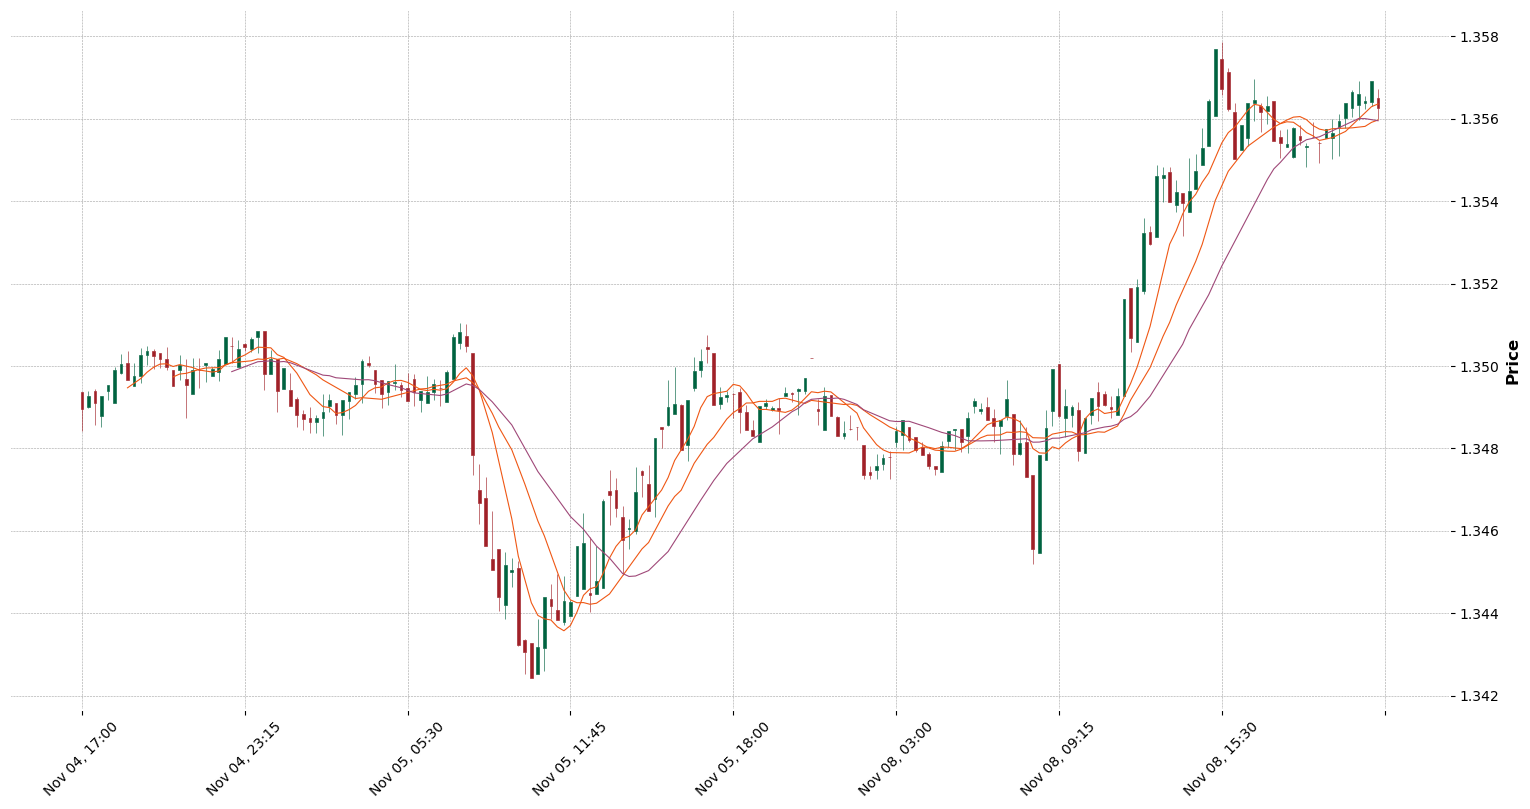

In [158]:
df = data.copy()
df['timestamp'] = df['timestamp'].apply(lambda x: datetime.strptime(x[:-6], '%Y-%m-%d %H:%M:%S'))
df.set_index('timestamp', inplace=True)
df.index.name = 'Date'

# df.index[0]
mpf.plot(df.iloc[0:200], type='candle', figsize=(20, 10), mav=(8, 15, 24, 200), style='charles')